# Load modules 

In [1]:
import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML

#base_dir = '/mnt/c/Users/since/Desktop/KdramaSpring/'
#data_dir = '/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/'
base_dir = '/mnt/c/Users/since/Desktop/KdramaApril/'
data_dir = os.path.join(base_dir, 'data', 'derivatives')
denoised_dir = os.path.join(base_dir, 'analysis', 'denoised')
Zdenoised_dir = os.path.join(base_dir, 'analysis', 'denoised_zscore')

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


# Load Parcell Mask

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/masking.py:858: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


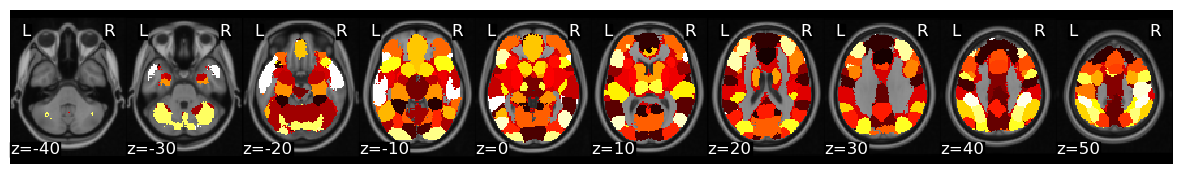

In [111]:
from nltools.mask import expand_mask
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
mask_x = expand_mask(mask)

mask.plot()

# setsize - 4
Get time-courses for each story and subject:

## Timepoints of the story line 

In [112]:
# FIVE stories 4 sub-05,06/ FOUR stories 4 S08 :
onset = [11, 131, 251, 371, 491]
offset = [124, 244, 364, 484, 604]  # <---------------- After Scanning, We need to increased volume to 606 !!

## Split stories 

In [165]:
#
subjects = ['05', '06']
sub_story_timeseries = {}
for sub in subjects:
    story = {}
    for i in np.arange(0,5):
        story_timeseries = {}
        for run in ['run-1','run-2']:   
            data = pd.read_csv(os.path.join(Zdenoised_dir,'Averaged_ROI', f'sub-{sub}_{run}_Average_ROI_n50.csv')) 
            story_timeseries[run] =  data[onset[i]:offset[i]]
        story[i] = story_timeseries
    sub_story_timeseries[sub] = story
#sub_story_timeseries['05'][0] #<----------------------------------------------sub // story // Run 
#sub_story_timeseries

In [22]:
ROIs = {}
for roi in np.arange(0,50):
    sub_rois = {}
    for sub in ['05','06']:
        story_roi = {}
        for j in np.arange(0,5):
            run_rois = {}
            story_timeseries = sub_story_timeseries[sub][j]
            for run in ['run-1','run-2']:
                #print(story_timeseries[run].shape)
                run_rois[run]  = story_timeseries[run].iloc[:, roi]
            story_roi[j] = pd.DataFrame(run_rois).reset_index() # <--------- For comparing neural resposes timepoints across participants [113TRs] 2mins 45 secs + 4.5 
        sub_rois[sub] = story_roi
    ROIs[roi] = sub_rois
#sub_rois['sub-02']
ROIs[5]['05'] # <----------------------------------------------------------roi/sub/story/run

{0:      index     run-1         run-2
 0       11 -0.526310  1.110723e-12
 1       12 -1.439680 -7.677835e-01
 2       13 -0.847276  5.169842e-01
 3       14  0.319914  4.932953e-01
 4       15  0.781471  9.452105e-01
 ..     ...       ...           ...
 108    119 -0.078501 -4.482880e-01
 109    120 -0.160864 -3.044253e-01
 110    121  0.876667  1.225392e-01
 111    122  0.942147  9.221605e-01
 112    123  1.333434  1.406896e+00
 
 [113 rows x 3 columns],
 1:      index         run-1     run-2
 0      131  1.277879e-01  0.129114
 1      132 -4.904782e-13 -0.750563
 2      133 -7.349402e-13  0.186658
 3      134  2.613331e-01  0.601657
 4      135 -3.734781e-01  0.388654
 ..     ...           ...       ...
 108    239 -1.205591e-15  0.893221
 109    240 -1.665601e+00  0.430610
 110    241 -1.208065e+00  0.756760
 111    242 -4.262332e-13 -0.242467
 112    243 -1.511064e-13  0.098823
 
 [113 rows x 3 columns],
 2:      index         run-1         run-2
 0      251 -8.999676e-13  9.9138

In [135]:
All_sub = {}
for sub in ['05','06']:
    story_roi = {}
    for j in np.arange(0,5):
        story_timeseries = sub_story_timeseries[sub][j]
        rois = {}
        for roi in np.arange(0,50):
            run_rois = {}
            for r, run in enumerate(['run-1','run-2']):
            #print(story_timeseries[run].shape)
                run_rois[run]= story_timeseries[run].iloc[:, roi]
            rois[roi] = pd.DataFrame(run_rois).reset_index(drop = True) # <--------- For comparing neural resposes timepoints across participants [113TRs] 2mins 45 secs + 4.5 
            #print(run_rois)
        story_roi[j] = rois
    All_sub[sub] = story_roi
type(All_sub['05'][0])
All_sub['05'][0] # <--------------------------------------------------- sub/story/roi/run/

{0:         run-1         run-2
 0   -0.577537  1.139310e-12
 1    0.093091 -1.222383e+00
 2   -0.760502  1.739115e-01
 3    0.525262  1.012355e+00
 4    0.113518  9.237487e-01
 ..        ...           ...
 108  0.348335  4.901330e-01
 109  0.030030  1.327935e+00
 110 -1.614086 -2.247627e-02
 111 -2.523201 -5.631780e-01
 112 -1.565041 -7.480695e-01
 
 [113 rows x 2 columns],
 1:         run-1         run-2
 0    0.120639  1.124424e-12
 1    0.354717  6.411919e-01
 2    1.064286  1.101349e+00
 3    1.801078  1.966258e+00
 4    1.590611  1.549216e+00
 ..        ...           ...
 108  0.269648  3.013039e-01
 109 -0.756783  9.539216e-01
 110 -0.736345  3.018739e-01
 111 -0.945913  2.278668e-01
 112  1.131322  1.078806e-01
 
 [113 rows x 2 columns],
 2:         run-1         run-2
 0    0.241727  1.047282e-12
 1   -0.561959 -7.564087e-01
 2   -0.883868 -1.394926e-01
 3   -0.124253  2.820222e-01
 4   -0.239004 -4.353983e-02
 ..        ...           ...
 108 -0.260321 -7.864863e-02
 109 -0.1

# Comparing ISC calculations

In [163]:
sampling_freq = .5

for story in np.arange(0,5):
    for roi in np.arange(0,50):
            sub = All_sub['05'][story][roi]

            f,a = plt.subplots(nrows=2, ncols=2, figsize=(4, 3))
            a[0,0].plot(sub, linewidth=2)
            a[0,0].set_ylabel('Avg Activity', fontsize=16)
            a[0,0].set_xlabel('Time (TR)', fontsize=18)
            a[0,0].set_title('Observed Data', fontsize=16)

            fft_data = fft(sub)
            freq = fftfreq(len(fft_data), 1/1.5)
            n_freq = int(np.floor(len(fft_data)/2))
            a[0,1].plot(freq[:n_freq], np.abs(fft_data)[:n_freq], linewidth=2)
            a[0,1].set_xlabel('Frequency (Hz)', fontsize=18)
            a[0,1].set_ylabel('Amplitude', fontsize=18)
            a[0,1].set_title('Power Spectrum', fontsize=18)

            circle_shift_data = circle_shift(sub)
            a[1,0].plot(circle_shift_data, linewidth=2, color='red')
            a[1,0].set_ylabel('Avg Activity', fontsize=16)
            a[1,0].set_xlabel('Time (TR)', fontsize=16)
            a[1,0].set_title('Circle Shifted Data', fontsize=16)

            fft_circle = fft(circle_shift_data)
            a[1,1].plot(freq[:n_freq], np.abs(fft_circle)[:n_freq], linewidth=2, color='red')
            a[1,1].set_xlabel('Frequency (Hz)', fontsize=18)
            a[1,1].set_ylabel('Amplitude', fontsize=18)
            a[1,1].set_title('Circle Shifted Power Spectrum', fontsize=18)
            plt.tight_layout()

KeyError: 0

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-

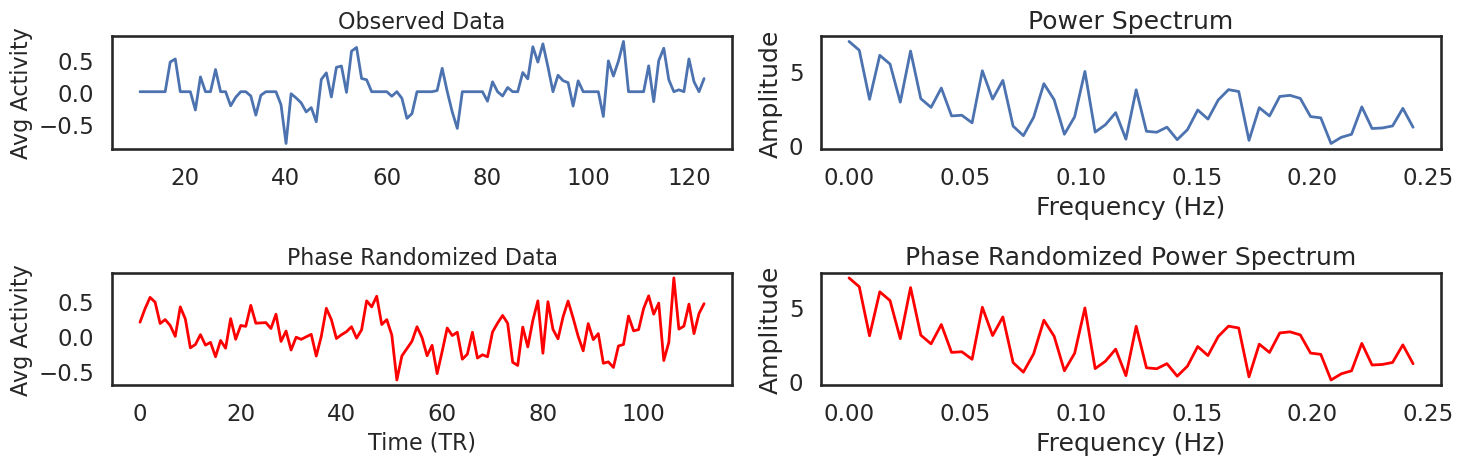

In [139]:
sampling_freq = .5
sub_rois =pd.DataFrame(sub_rois['sub-02'][0])

f,a = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
a[0,0].plot(sub_rois[run], linewidth=2)
a[0,0].set_ylabel('Avg Activity', fontsize=16)
a[0,1].set_xlabel('Time (TR)', fontsize=18)
a[0,0].set_title('Observed Data', fontsize=16)

fft_data = fft(sub_rois[run])
freq = fftfreq(len(fft_data), 1/sampling_freq)
n_freq = int(np.floor(len(fft_data)/2))
a[0,1].plot(freq[:n_freq], np.abs(fft_data)[:n_freq], linewidth=2)
a[0,1].set_xlabel('Frequency (Hz)', fontsize=18)
a[0,1].set_ylabel('Amplitude', fontsize=18)
a[0,1].set_title('Power Spectrum', fontsize=18)

phase_random_data = phase_randomize(sub_rois[run])
a[1,0].plot(phase_random_data, linewidth=2, color='red')
a[1,0].set_ylabel('Avg Activity', fontsize=16)
a[1,0].set_xlabel('Time (TR)', fontsize=16)
a[1,0].set_title('Phase Randomized Data', fontsize=16)

fft_phase = fft(phase_random_data)
a[1,1].plot(freq[:n_freq], np.abs(fft_phase)[:n_freq], linewidth=2, color='red')
a[1,1].set_xlabel('Frequency (Hz)', fontsize=18)
a[1,1].set_ylabel('Amplitude', fontsize=18)
a[1,1].set_title('Phase Randomized Power Spectrum', fontsize=18)

plt.tight_layout()

In [159]:
print("stats_circle:")

for story in np.arange(0,5):
    sub = pd.DataFrame(All_sub['06'][story][28] ) #<------ roi = 28
    stats_circle = isc(sub, method='circle_shift', n_bootstraps=5000, return_bootstraps=True)
    print(f"sub-06_story-{story}__ISC: {stats_circle['isc']:.02}, p = {stats_circle['p']:.03}")

stats_circle:
sub-06_story-0__ISC: -0.014, p = 0.837
sub-06_story-1__ISC: -0.027, p = 0.725
sub-06_story-2__ISC: -0.012, p = 0.896
sub-06_story-3__ISC: 0.19, p = 0.037
sub-06_story-4__ISC: 1.4e-05, p = 1.0


In [160]:
print("stats_phase:")
for story in np.arange(0,5):
    sub = pd.DataFrame(All_sub['05'][story][28]) #<------ roi = 28
    stats_phase = isc(sub, method='phase_randomize', n_bootstraps=5000, return_bootstraps=True)
    print(f"stats_phase: sub-06_story-{story}__ISC: {stats_phase['isc']:.02}, p = {stats_phase['p']:.03}")

stats_phase:
stats_phase: sub-06_story-0__ISC: -0.01, p = 0.919
stats_phase: sub-06_story-1__ISC: -0.051, p = 0.636
stats_phase: sub-06_story-2__ISC: 0.1, p = 0.351
stats_phase: sub-06_story-3__ISC: -0.12, p = 0.355
stats_phase: sub-06_story-4__ISC: 0.11, p = 0.376


Text(0.5, 1.0, 'Bootstrapped Pairwise Similarity')

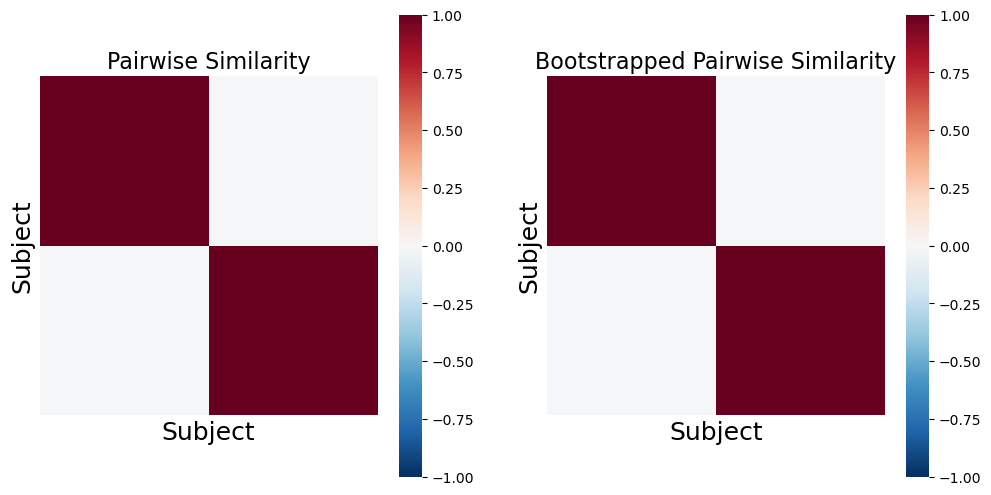

In [148]:
def bootstrap_subject_matrix(similarity_matrix, random_state=None):
    '''This function shuffles subjects within a similarity matrix based on recommendation by Chen et al., 2016'''
    
    random_state = check_random_state(random_state)
    n_sub = similarity_matrix.shape[0]
    bootstrap_subject = sorted(random_state.choice(np.arange(n_sub), size=n_sub, replace=True))
    return similarity_matrix[bootstrap_subject, :][:, bootstrap_subject]

sub_rois =pd.DataFrame(All_sub['05'][0][28])
similarity = 1 - pairwise_distances(pd.DataFrame(sub_rois).T, metric='correlation')

f,a = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
sns.heatmap(similarity, square=True, cmap='RdBu_r', vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=a[0])
a[0].set_ylabel('Subject', fontsize=18)
a[0].set_xlabel('Subject', fontsize=18)
a[0].set_title('Pairwise Similarity', fontsize=16)

sns.heatmap(bootstrap_subject_matrix(similarity), square=True, cmap='RdBu_r', vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=a[1])
a[1].set_ylabel('Subject', fontsize=18)
a[1].set_xlabel('Subject', fontsize=18)
a[1].set_title('Bootstrapped Pairwise Similarity', fontsize=16)

In [161]:
print("stats_boot:")
for story in np.arange(0,5):
    sub = pd.DataFrame(All_sub['05'][story][28])
    stats_boot = isc(sub, method='bootstrap', n_bootstraps=5000, return_bootstraps=True)
    print(f"stats_boot: sub-05_story-{story}_ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot:
stats_boot: sub-05_story-0_ISC: -0.01, p = 0.0002
stats_boot: sub-05_story-1_ISC: -0.051, p = 0.0002
stats_boot: sub-05_story-2_ISC: 0.1, p = 0.0002
stats_boot: sub-05_story-3_ISC: -0.12, p = 0.0002
stats_boot: sub-05_story-4_ISC: 0.11, p = 0.0002


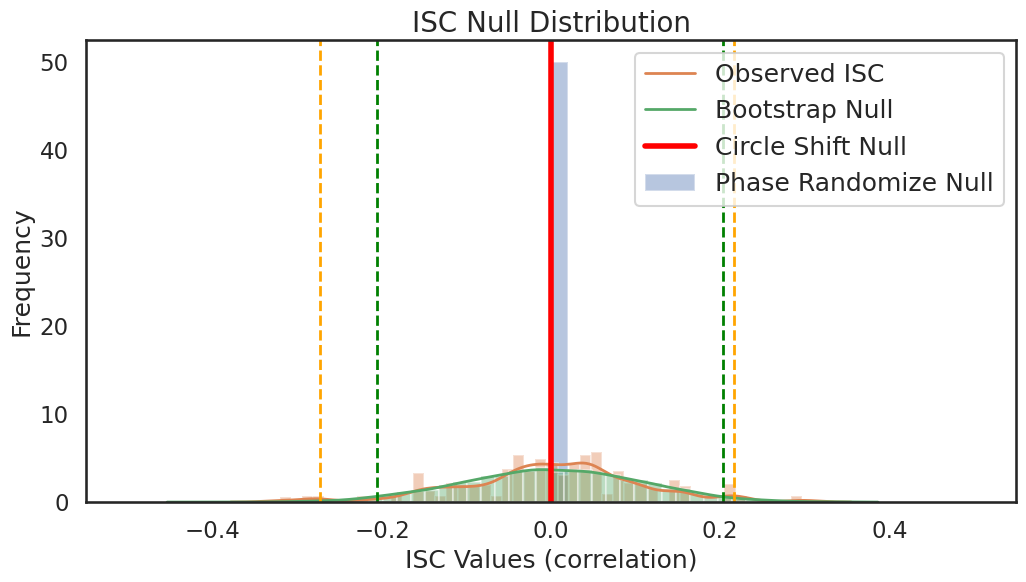

In [158]:
plt.figure(figsize=(12,6))
sns.distplot(stats_boot['null_distribution'] - stats_boot['isc'], kde=True, label='Bootstrap')
sns.distplot(stats_circle['null_distribution'], kde=True, label='Bootstrap')
sns.distplot(stats_phase['null_distribution'], kde=True, label='Bootstrap')
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('ISC Values (correlation)', fontsize=18)
plt.title('ISC Null Distribution', fontsize=20)
plt.axvline(stats_boot['isc'], linestyle='-', color='red', linewidth=4)
plt.legend(['Observed ISC', 'Bootstrap Null','Circle Shift Null', 'Phase Randomize Null'], fontsize=18)

plt.axvline(stats_boot['ci'][0] - stats_boot['isc'], linestyle='--', color='blue')
plt.axvline(stats_boot['ci'][1] - stats_boot['isc'], linestyle='--', color='blue')

plt.axvline(stats_circle['ci'][0], linestyle='--', color='orange')
plt.axvline(stats_circle['ci'][1], linestyle='--', color='orange')

plt.axvline(stats_phase['ci'][0], linestyle='--', color='green')
plt.axvline(stats_phase['ci'][1], linestyle='--', color='green')

# Sliding Time Window

## Load titles of experiment stimulus

In [171]:
import scipy.io as sio
#for sub in subjects: 

All_story = {}
subjects = ['05', '06']
for sub in subjects:
    mat = sio.loadmat(glob.glob(os.path.join('/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA/fMRISpring', f'sub-{sub}_task-recall_countered-*_stimulusCond-*_*.mat'))[0])
    story = ['Neighbors']
    for i in np.arange(0,4):
        temp_story = mat['data'][0][0][7][0][i][0]
        story = np.append(story, temp_story)
    All_story[sub] = story

    
# sub-08 
mat = sio.loadmat(glob.glob(os.path.join('/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA/fMRISpring', 'sub-102_task-recall_counter-*_session-01_cond-1_clock-*.mat'))[0])
story2 = ['Youngsignal']
for i in np.arange(0,6):
    stroy2 = mat['data'][0][0][8][0][i]
    story2 = np.append(story2, stroy2)
#All_story
story2 = np.insert(story2, 4, 'King')
story2
All_story['08'] = story2
All_story

{'05': array(['Neighbors', 'Runningman', 'First Date', 'Way To School',
        'Business Lunch'], dtype='<U14'),
 '06': array(['Neighbors', 'Runningman', 'Business Lunch', 'Way To School',
        'First Date'], dtype='<U14'),
 '08': array(['Youngsignal', 'Blind Date', 'Way To School', 'Business Lunch',
        'King', 'Runningman', 'neighbors', 'TwoBoys'], dtype='<U14')}

## Calculate sliding window ISC in S0[5-6]

In [429]:
ROIs = {}
for roi in [5, 28, 32]:
    sub_rois = {}
    for sub in ['05','06']:
        story_roi = {}
        for j in np.arange(0,5):
            run_rois = {}
            story_timeseries = sub_story_timeseries[sub][j]
            for run in story_timeseries:
                run_rois[run]  = story_timeseries[run].iloc[:, roi]
            story_roi[j] = pd.DataFrame(run_rois)
        sub_rois[sub] = story_roi
    ROIs[roi] = sub_rois #<---------------------------------------- roi / sub/ story/ run 
#sub_rois['sub-02']

In [495]:
import pandas as pd
from tqdm import tqdm
#roi =28 
# 슬라이딩 타임 윈도우 크기 및 간격 설정
window_size = 30 #TR - 45secs 
stride = 1  # 윈도우 이동 간격 (TR 단위)

All_sliding_r = {}
All_sliding_p = {}
for roi in tqdm([5, 28, 32]):
    sub_rois = ROIs[roi]
    sub_sliding_r = {}
    sub_sliding_p = {}
    for sub in ['05','06','08']:
    #for sub in ['05', '06']:
        storyNum = All_story[sub]
        sliding_r = {}
        sliding_p = {}
        for num in np.arange(storyNum.shape[0]):
            data = pd.DataFrame(sub_rois[sub][num]).reset_index(drop = True)
            window_isc_r = []
            window_isc_p = []
            for i in range(0, data.shape[0] - window_size + 1, stride):
                window = data.iloc[i:i + window_size]
                stats = isc(window, n_bootstraps=5000, metric='median', method='bootstrap')
                window_isc_r.append(stats['isc'])
                window_isc_p.append(stats['p'])
            result_r = pd.Series(window_isc_r, index=data.index[window_size - 1:])
            result_p = pd.Series(window_isc_p, index=data.index[window_size - 1:])
            sliding_r[storyNum[num]] = result_r
            sliding_p[storyNum[num]] = result_p
        sub_sliding_r[sub] = sliding_r
        sub_sliding_p[sub] = sliding_p
    All_sliding_r[roi] = sub_sliding_r
    All_sliding_p[roi] = sub_sliding_p

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [52:16<00:00, 1045.40s/it]
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/sincerely/.co

In [531]:
All_sliding_r[32]['06']['Runningman']

29    -0.060532
30     0.006970
31    -0.029930
32    -0.031301
33     0.000246
         ...   
108   -0.495219
109   -0.502293
110   -0.494277
111   -0.525433
112   -0.538668
Length: 84, dtype: float64

## Calculate sliding window in S08
- subject timeseries / subject roi / Sliding Window ISC 계산하기 : run 1& 2, run3&4

In [364]:
# 나는 이야기마다 segmentation 해서... 저장하기
#onset = [11, 131, 251, 371, 491]
#offset = [124, 244, 364, 484, 604]

onset = [11, 120, 240, 360]
offset = [116, 236, 356, 476] # 2분 30초 

sub = '08'
story = {}
for i in np.arange(0,4):
    story_timeseries = {}
    for run in ['run-1','run-2']:   
        data = pd.read_csv(os.path.join(Zdenoised_dir,'Averaged_ROI', f'sub-08_{run}_Average_ROI_n50.csv')) 
        #print(data)
        story_timeseries[run] =  pd.DataFrame(data[onset[i]:offset[i]])
    story[i] = story_timeseries
    for run in ['run-3', 'run-4']:   
        data = pd.read_csv(os.path.join(Zdenoised_dir,'Averaged_ROI', f'sub-{sub}_{run}_Average_ROI_n50.csv')) 
        story_timeseries[run] =  data[onset[i]:offset[i]]
    story[i+4] = story_timeseries
sub_story_timeseries['08'] = story
sub_story_timeseries['08']



{0: {'run-1':                 0             1             2             3             4  \
  11  -3.424507e-12 -3.491280e-12 -3.217735e-12 -3.218472e-12 -3.757248e-12   
  12  -1.493011e+00 -1.607567e+00 -8.051195e-01  8.022950e-02 -3.037858e+00   
  13  -2.409790e-12 -2.462233e-12 -2.257826e-12 -2.253223e-12 -2.668527e-12   
  14  -3.750836e-01 -5.868667e-02 -3.970373e-01 -1.921999e-01 -5.549855e-01   
  15  -5.132647e-02  1.117719e+00 -4.592575e-01  8.743417e-02 -1.637984e+00   
  ..            ...           ...           ...           ...           ...   
  111  1.045230e+00  8.464843e-01 -3.311636e-01  6.421819e-01  9.679473e-01   
  112 -7.207781e-02 -1.416459e-01  2.399273e-01  2.056764e-01  6.322575e-01   
  113  9.014409e-01  3.038411e-01  5.098508e-02  6.427863e-01 -2.568847e-01   
  114 -3.303348e-12 -3.365542e-12 -3.115977e-12 -3.114360e-12 -3.625155e-12   
  115  2.790253e-01 -1.082390e+00  3.617346e-02 -2.860936e-01 -4.973531e+00   
  
                  5             6    

In [430]:
#ROIs = {}
for roi in [5, 28, 32]:
    #sub_rois = {}
    for sub in ['08']:
        story_roi = {}
        for j in np.arange(0,8):
            run_rois = {}
            story_timeseries = sub_story_timeseries[sub][j]
            for run in story_timeseries:
                run_rois[run]  = story_timeseries[run].iloc[:, roi]
            story_roi[j] = pd.DataFrame(run_rois)
    sub_rois['08'] = story_roi
    ROIs[roi] = sub_rois
#sub_rois['sub-02']

In [366]:
import pandas as pd
#roi =28 
# 슬라이딩 타임 윈도우 크기 및 간격 설정
window_size = 30 #TR - 60secs 
stride = 1  # 윈도우 이동 간격 (TR 단위)
sub = '08'


storyNum = All_story[sub]
for roi in tqdm([5, 28, 32]):
    sub_rois = ROIs[roi]
    for num in np.arange(storyNum.shape[0]):
        data = pd.DataFrame(sub_rois[sub][num])
        window_isc_r = []
        window_isc_p = []
        for i in range(0, data.shape[0] - window_size + 1, stride):
            window = data.iloc[i:i + window_size] # <---------------------------------------------여기가 핵심.. Data의 범위를 지정해주는 곳! 
            stats = isc(window, n_bootstraps=5000, metric='median', method='bootstrap') # <------- window 별로 ISC 계산 
            window_isc_r.append(stats['isc'])
            window_isc_p.append(stats['p'])
        result_r = pd.Series(window_isc_r, index=data.index[window_size - 1:])
        result_p = pd.Series(window_isc_p, index=data.index[window_size - 1:])
        sliding_r[storyNum[num]] = result_r
        sliding_p[storyNum[num]] = result_p
    sub_sliding_r['08'] = sliding_r
    sub_sliding_p['08'] = sliding_p
    All_sliding_r[roi] = sub_sliding_r
    All_sliding_p[roi] = sub_sliding_p
All_sliding_p[28]['08']['Neighbors']

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [23:35<00:00, 471.71s/it]


29     0.0002
30     0.0002
31     0.0002
32     0.0002
33     0.0002
        ...  
108    0.0002
109    0.0002
110    0.0002
111    0.0002
112    0.0002
Length: 84, dtype: float64

In [ ]:
storyNum = All_story['05']
for position, sub in enumerate(['05', '06', '08']):
    for num in np.arange(storyNum.shape[0]):
        story = storyNum[num]
        roi28 = pd.DataFrame(All_sliding_r[28][sub][story])
        roi32 = pd.DataFrame(All_sliding_r[32][sub][story])
        roi5 = pd.DataFrame(All_sliding_r[5][sub][story])       
        result4story = pd.concat([roi28,roi32,roi5], axis = 1)
        
        fig, axes = plt.subplots(3, 5)
        axes[i, num].plot(result4story)
        axes[i, num].title(f"Sliding Window ISC in the {storyNum[num]} of sub-{sub}")
        axes[i, num].xlabel("30 TRs Window")
        axes[i, num].ylabel("ISC")
        plt.show()

# Plotting Sliding Time window with Dynamic Counting

In [485]:
Runningman_event_TR = [11,24, 42, 53, 97]
Dance_event_TR = [5,25, 48, 97]
Date_event_TR = []
Neighbor_event_TR = []
Business_evemt_TR =[] 

In [420]:
All_sliding_r

{}

In [523]:
h_S05_Runningman = pd.DataFrame(All_sliding_r[28]['05']['Runningman']).reset_index(drop=True)
h_S06_Runningman = pd.DataFrame(All_sliding_r[28]['06']['Runningman']).reset_index(drop=True)
h_S08_Runningman = pd.DataFrame(All_sliding_r[28]['08']['Runningman']).reset_index(drop=True)

v_S05_Runningman = pd.DataFrame(All_sliding_r[32]['05']['Runningman']).reset_index(drop=True)
v_S06_Runningman = pd.DataFrame(All_sliding_r[32]['06']['Runningman']).reset_index(drop=True)
v_S08_Runningman = pd.DataFrame(All_sliding_r[32]['08']['Runningman']).reset_index(drop=True)

T_S05_Runningman = pd.DataFrame(All_sliding_r[5]['05']['Runningman']).reset_index(drop=True)
T_S06_Runningman = pd.DataFrame(All_sliding_r[5]['06']['Runningman']).reset_index(drop=True)
T_S08_Runningman = pd.DataFrame(All_sliding_r[5]['08']['Runningman']).reset_index(drop=True)

h_S05_WayToSchool = pd.DataFrame(All_sliding_r[28]['05']['Way To School']).reset_index(drop=True)
h_S06_WayToSchool = pd.DataFrame(All_sliding_r[28]['06']['Way To School']).reset_index(drop=True)
h_S08_WayToSchool = pd.DataFrame(All_sliding_r[28]['08']['Way To School']).reset_index(drop=True)

v_S05_WayToSchool = pd.DataFrame(All_sliding_r[32]['05']['Way To School']).reset_index(drop=True)
v_S06_WayToSchool = pd.DataFrame(All_sliding_r[32]['06']['Way To School']).reset_index(drop=True)
v_S08_WayToSchool = pd.DataFrame(All_sliding_r[32]['08']['Way To School']).reset_index(drop=True)

T_S05_WayToSchool = pd.DataFrame(All_sliding_r[5]['05']['Way To School']).reset_index(drop=True)
T_S06_WayToSchool = pd.DataFrame(All_sliding_r[5]['06']['Way To School']).reset_index(drop=True)
T_S08_WayToSchool = pd.DataFrame(All_sliding_r[5]['08']['Way To School']).reset_index(drop=True)

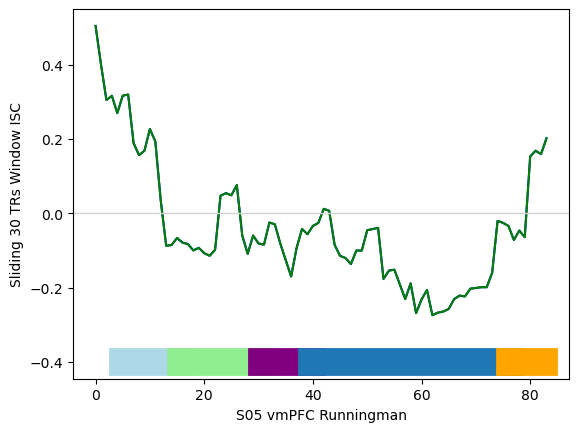

In [532]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
plt.plot(pd.DataFrame(All_sliding_r[28]['05']['Runningman']).reset_index(drop=True), color = 'blue')
plt.plot(pd.DataFrame(All_sliding_r[5]['05']['Runningman']).reset_index(drop=True), color = 'green')
#plt.plot(v_S06_WayToSchool)
plt.axhline(0.0, 0, 1.0, color='lightgray', linestyle='solid', linewidth=1)
#plt.axhline(-0.5, 0.05,  Dance_event_TR[0]/100, color='blue', linestyle='solid', linewidth=20)
plt.axhline(-0.4,  Runningman_event_TR[0]/110,  Runningman_event_TR[1]/110, color='lightblue', linestyle='solid', linewidth=20)
plt.axhline(-0.4,  Runningman_event_TR[1]/110,  Runningman_event_TR[2]/110, color='lightgreen', linestyle='solid', linewidth=20)
plt.axhline(-0.4,  Runningman_event_TR[2]/110,  Runningman_event_TR[3]/110, color='purple', linestyle='solid', linewidth=20)
plt.axhline(-0.4,  Runningman_event_TR[3]/110,  Runningman_event_TR[4]/110, linestyle='solid', linewidth=20)
plt.axhline(-0.4,  Runningman_event_TR[4]/110,  0.95, color='orange', linestyle='solid', linewidth=20)
plt.ylabel("Sliding 30 TRs Window ISC")
plt.xlabel("S05 vmPFC Runningman")

plt.show()

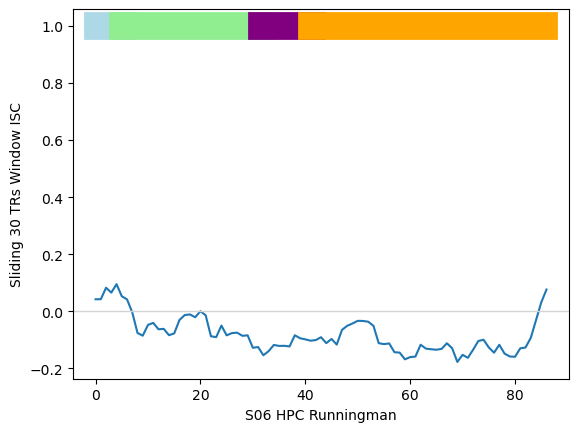

In [407]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
#plt.plot(v_S06_Neighbors)
plt.plot(h_S08_Runningman.reset_index(drop=True))
plt.axhline(0.0, 0, 1.0, color='lightgray', linestyle='solid', linewidth=1)
plt.axhline(1.0, 0.05,  Runningman_event_TR[0]/110, color='lightblue', linestyle='solid', linewidth=20)
plt.axhline(1.0,  Runningman_event_TR[0]/110, Runningman_event_TR[1]/110, color='lightgreen', linestyle='solid', linewidth=20)
plt.axhline(1.0,  Runningman_event_TR[1]/110,  Runningman_event_TR[2]/110, color='purple', linestyle='solid', linewidth=20)
plt.axhline(1.0,  Runningman_event_TR[2]/110,  0.95, color='orange', linestyle='solid', linewidth=20)
plt.ylabel("Sliding 30 TRs Window ISC")
plt.xlabel("S06 HPC Runningman")

plt.show()

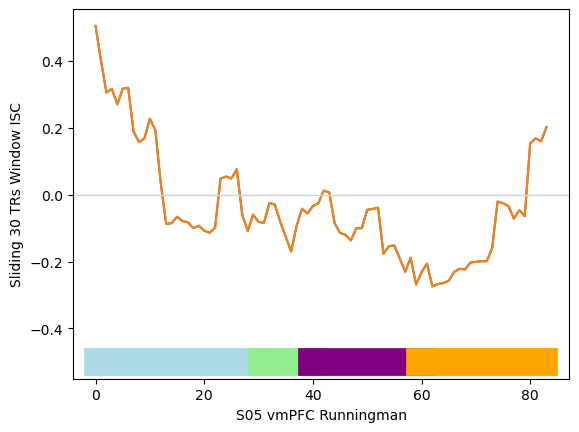

In [419]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
plt.plot(v_S05_Runningman)
plt.plot(h_S05_Runningman)
plt.axhline(0.0, 0, 1.0, color='lightgray', linestyle='solid', linewidth=1)
#plt.axhline(1.0, 11/110,Runningman_event_TR[0]/110,color='lightgray', linestyle='solid', linewidth=20)
plt.axhline(-0.5, 0.05,  Runningman_event_TR[1]/110, color='lightblue', linestyle='solid', linewidth=20)
plt.axhline(-0.5,  Runningman_event_TR[1]/110, Runningman_event_TR[2]/110, color='lightgreen', linestyle='solid', linewidth=20)
plt.axhline(-0.5,  Runningman_event_TR[2]/110,  Runningman_event_TR[3]/110, color='purple', linestyle='solid', linewidth=20)
plt.axhline(-0.5,  Runningman_event_TR[3]/110,  0.95, color='orange', linestyle='solid', linewidth=20)
plt.ylabel("Sliding 30 TRs Window ISC")
plt.xlabel("S05 vmPFC Runningman")

plt.show()

In [121]:
storyNum = All_story['05']
resutls = {}
for position, sub in enumerate(['05', '06']):
    result4story = {}
    for num in np.arange(storyNum.shape[0]):
        story = storyNum[num]
        roi28 = pd.DataFrame(All_sliding_r[28][sub][story])
        roi32 = pd.DataFrame(All_sliding_r[32][sub][story])
        roi5 = pd.DataFrame(All_sliding_r[5][sub][story])       
        result4story[num] = pd.concat([roi28,roi32,roi5], axis = 1)
    resutls[sub] = result4story 

In [209]:
story = pd.DataFrame(All_sliding_r[28]['06']['Runningman'])
story = story.reset_index(drop = True)
story.columns = ['isc']
story.loc[(story['isc'] < 0)]


,isc
18,-0.013360
19,-0.015176
26,-0.025580
28,-0.089322
29,-0.101338
30,-0.095563
31,-0.040814
32,-0.019200
33,-0.037594
34,-0.043942


In [98]:
np.arange(storyNum.shape[0])

array([0, 1, 2, 3, 4])

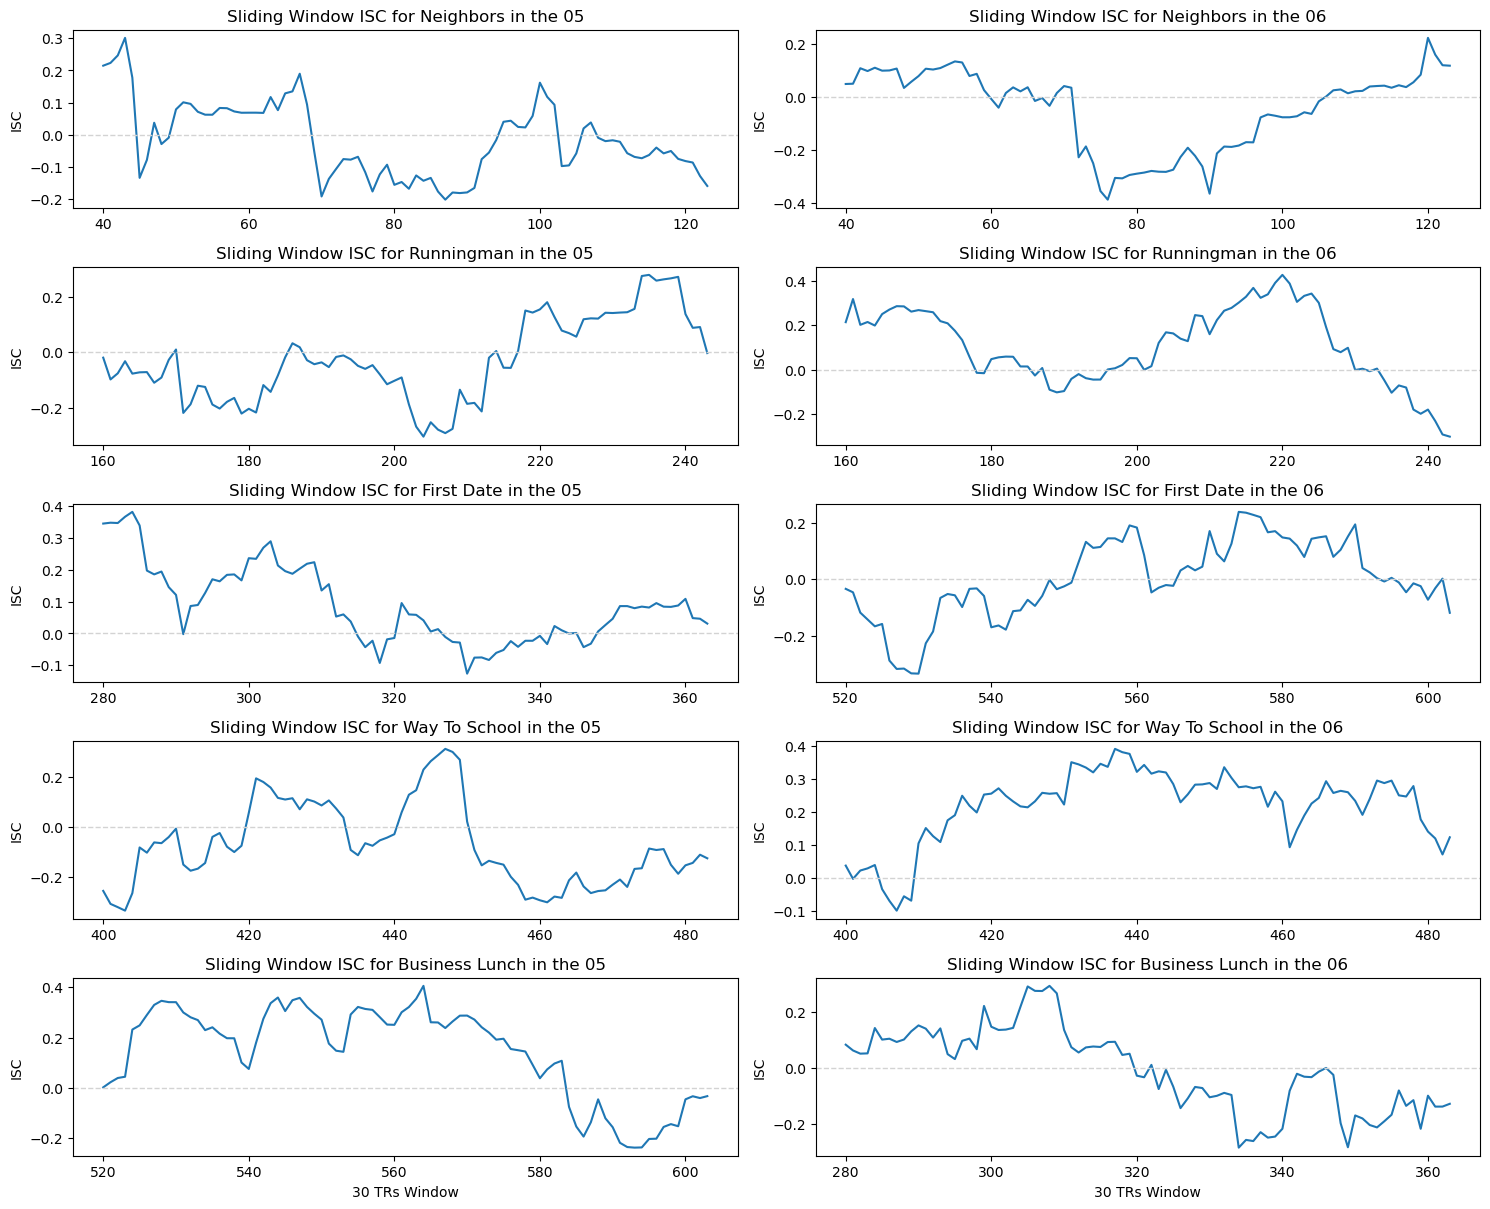

In [147]:
#profile 4 HPC 

fig, axes = plt.subplots(5, 2, figsize = (15,12))     
for position, sub in enumerate(['05', '06']):  
    for num in np.arange(storyNum.shape[0]):
        #print(num, position)
        axes[num, position].plot(pd.DataFrame(All_sliding_r[28][sub][storyNum[num]]))
        axes[num, position].axhline(0.0, 0, 1, color='lightgray', linestyle='--', linewidth=1)
        axes[num, position].set_title(f"Sliding Window ISC for {storyNum[num]} in the {sub}")
        axes[num, position].set_ylabel("ISC")
fig.tight_layout()
axes[4, 0].set_xlabel("30 TRs Window")
axes[4, 1].set_xlabel("30 TRs Window")
plt.show()

## 행동 데이터 결과와 비교하기 

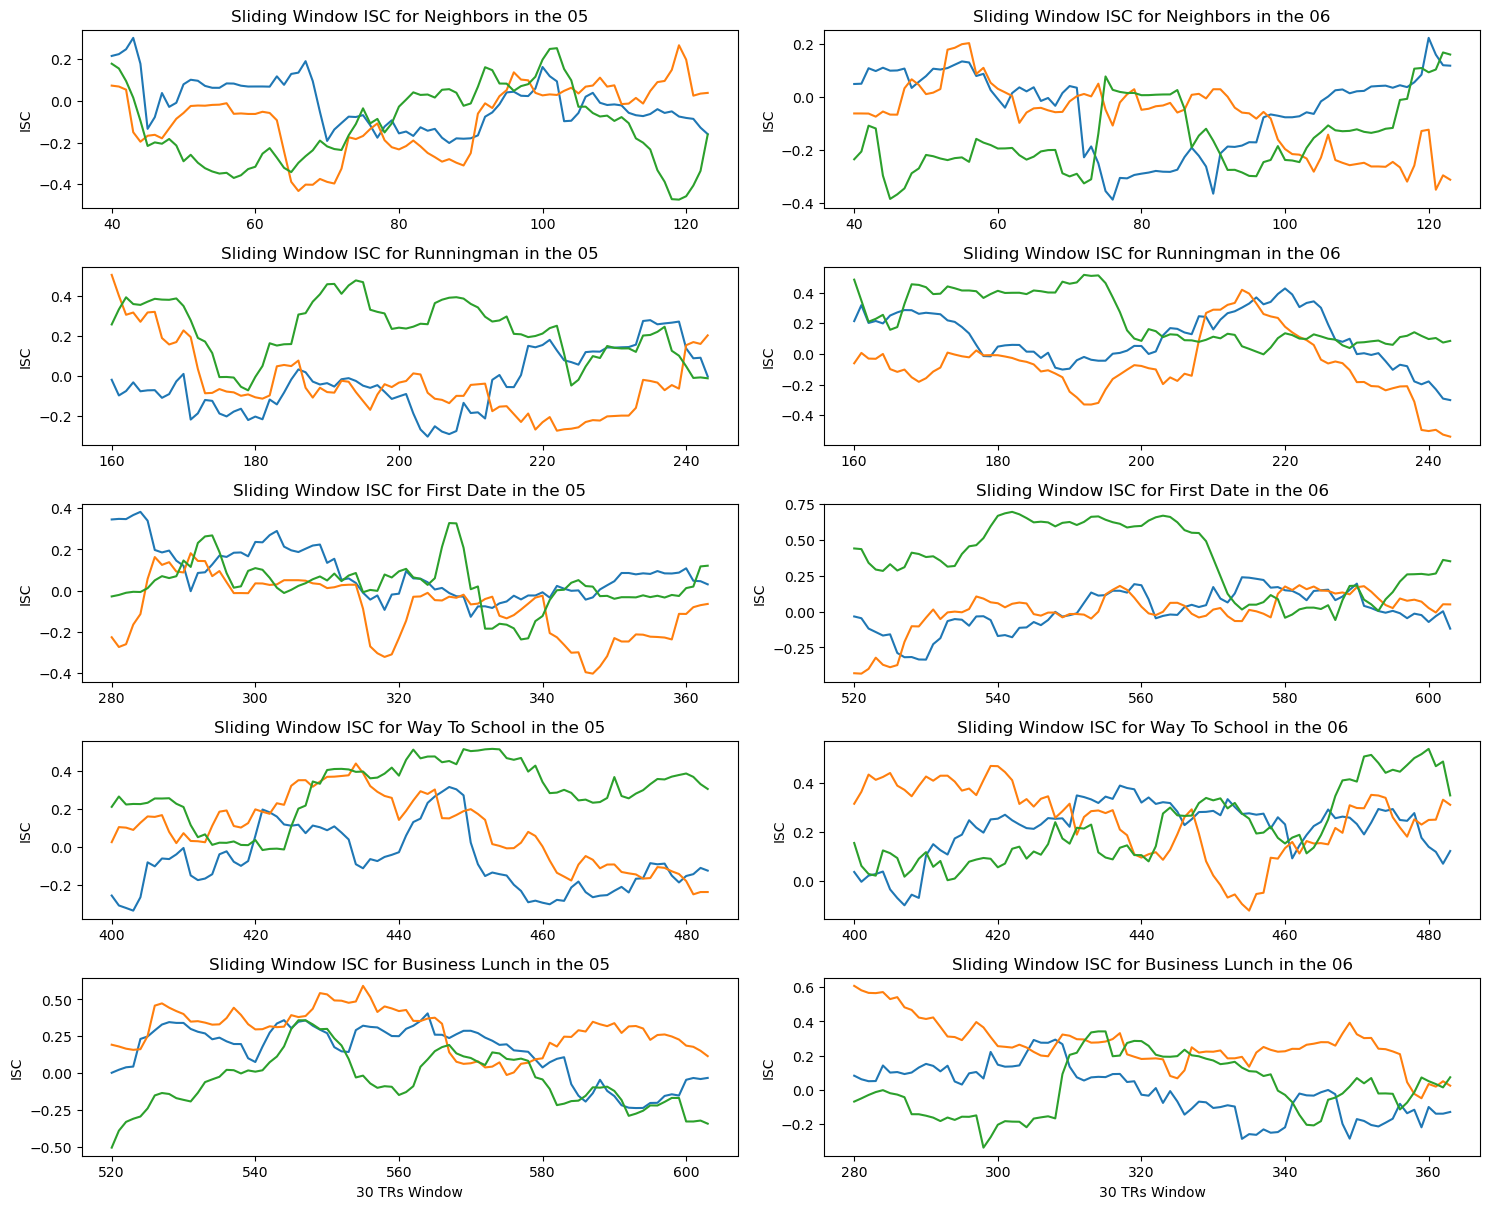

In [139]:
fig, axes = plt.subplots(5, 2, figsize = (15,12))     
for position, sub in enumerate(['05', '06']):  
    for num in np.arange(storyNum.shape[0]):
        #print(num, position)
        axes[num, position].plot(pd.DataFrame(resutls[sub][num]))
        axes[num, position].set_title(f"Sliding Window ISC for {storyNum[num]} in the {sub}")
        axes[num, position].set_ylabel("ISC")
fig.tight_layout()
axes[4, 0].set_xlabel("30 TRs Window")
axes[4, 1].set_xlabel("30 TRs Window")
plt.show()

# Averaged sliding window ISC for each story across subjects 

In [ ]:
storyNum = All_story['05']
for position, sub in enumerate(['05', '06', '08']):
    for num in np.arange(storyNum.shape[0]):
        story = storyNum[num]
        roi28 = pd.DataFrame(All_sliding_r[28][sub][story])
        roi32 = pd.DataFrame(All_sliding_r[32][sub][story])
        roi5 = pd.DataFrame(All_sliding_r[5][sub][story])    
        
        result4story = pd.concat([roi28,roi32,roi5], axis = 1)
        colnames = result4story.columns
        scaler = StandardScaler()
        Zscores = scaler.fit(result4story)
        new_colnames = [i+'_Zscore' for i in colnames]
        
        fig, axes = plt.subplots(3, 5)
        axes[i, num].plot(result4story)
        axes[i, num].title(f"Sliding Window ISC in the {storyNum[num]} of sub-{sub}")
        axes[i, num].xlabel("30 TRs Window")
        axes[i, num].ylabel("ISC")
        plt.show()

In [ ]:
# 분석 대상 : Neighbors, BussinessLunch, BlindDate, WayToSchool, Runningman
storyNum = All_story['05']

# Transform Pearson P to Fisher's Z 
# 이때 개별 참가자의 이야기 간 Z 점수 정규화를 진행하였다.. 맞겠쥐,..? 
sub_data = pd.DataFrame()
for roi in [28, 32, 5]:
    for sub in ['05','06','08']:
        temp =  pd.concat([pd.DataFrame(All_sliding_r[roi][sub][story]), 
        temp.
            

# 이야기별 참가자 평균 구하기기 


In [ ]:
# 개별 이야기를 행동 패턴과 비교해보기
# Neighbors, BussinessLunch, BlindDate, WayToSchool, 

# Load Behavior data 

In [6]:
rois = pd.read_csv('https://raw.githubusercontent.com/naturalistic-data-analysis/tutorial_development/master/hypertools/rois.csv', header=None, names=['ID', 'Region'])
rois

,ID,Region
0,0,Anterior MPFC
1,1,Fusiform/parahippocampus
2,2,DMPFC
3,3,Sensorimotor/postcentral gyrus
4,4,V1
5,5,TPJ posterior supra marginal/angular gyrus
6,6,PCC/precuneus
7,7,Thalamus
8,8,SMA
9,9,Precentral gyrus


In [367]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import glob

file_dir = glob.glob(os.path.join('/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA/rubrics/KClips'))
#glob.glob(os.path.join(fmriprep_dir,'sub-01','anat', '*preproc_T1w.nii.gz'))
file = file_dir[0]
print(file)

/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA/rubrics/KClips


### Runningman

In [467]:
#Runningman
Runningman = pd.read_excel(os.path.join(file,'BusRubrics.xlsx'), sheet_name = 'Runningman', usecols = [32,33])
Runningman.columns = {'SceneP(First)', 'SceneP(Second)'}
Runningman = Runningman.fillna(0.0)
Runningman = Runningman[2::2] # 1부터 2행마다 
Runningman.reset_index(drop=True)
Runningman['Update_p'] = Runningman['SceneP(Second)'] - Runningman['SceneP(First)'] 

Runningman = Runningman.astype({ 'Update_p' : 'float', 'SceneP(First)': 'float', 'SceneP(Second)': 'float'})
#Runningman['Update_p'] = Runningman['Update_p'])
Runningman

,SceneP(First),SceneP(Second),Update_p
2,0.461538,0.615385,0.153846
4,0.923077,1.000000,0.076923
6,0.000000,0.846154,0.846154
8,0.076923,0.846154,0.769231
10,0.076923,0.692308,0.615385
12,0.000000,0.076923,0.076923
14,1.000000,0.923077,-0.076923
16,0.461538,0.153846,-0.307692
18,0.076923,0.384615,0.307692
20,0.000000,0.230769,0.230769


In [468]:
Runningman_update = pd.DataFrame(Runningman['Update_p'])
Runningman_update.sort_values(by='Update_p' ,ascending=False)

,Update_p
6,0.846154
8,0.769231
10,0.615385
30,0.461538
58,0.461538
78,0.384615
24,0.384615
34,0.384615
64,0.307692
60,0.307692


In [483]:
Runningman = Runningman.loc[(Runningman['Update_p'] >0),:]
print(Runningman.shape)
Runningman.sort_values(by=['Update_p','SceneP(Second)'] ,ascending=False)

(25, 3)


,SceneP(First),SceneP(Second),Update_p
6,0.000000,0.846154,0.846154
8,0.076923,0.846154,0.769231
10,0.076923,0.692308,0.615385
30,0.000000,0.461538,0.461538
58,0.000000,0.461538,0.461538
78,0.076923,0.461538,0.384615
24,0.000000,0.384615,0.384615
34,0.461538,0.846154,0.384615
64,0.153846,0.461538,0.307692
18,0.076923,0.384615,0.307692


In [477]:
After = Runningman.sort_values(by=['SceneP(Second)','Update_p'] ,ascending=False)
After.sort_values(by='SceneP(First)' ,ascending=True)
After = 

,SceneP(First),SceneP(Second),Update_p
24,0.000000,0.384615,0.384615
60,0.000000,0.307692,0.307692
52,0.000000,0.307692,0.307692
20,0.000000,0.230769,0.230769
44,0.000000,0.230769,0.230769
74,0.000000,0.000000,0.000000
46,0.000000,0.230769,0.230769
30,0.000000,0.461538,0.461538
56,0.000000,0.230769,0.230769
6,0.000000,0.846154,0.846154


In [433]:
Runningman_Time = pd.DataFrame(index = range(0,125), columns = {'Update_p'})
for i in np.arange(Runningman.shape[0]-1):
    onset = round(Runningman['onset_TR'][i])-1
    offset = round(Runningman['onset_TR'][i+1])-1
    #print('onset & offset' , onset, offset)
    Runningman_Time['Update_p'][onset:offset] = Runningman['Update_p'][i]
Runningman_Time[116:125] = -0.153846# 뒷 부분에 대한 ANNOTATION 이 달라져서 평균 값을 넣었다. 
Runningman_Time

,Update_p
0,105.666667
1,105.666667
2,105.666667
3,105.666667
4,105.666667
...,...
120,-0.153846
121,-0.153846
122,-0.153846
123,-0.153846


In [436]:
Runningman_Time_a = (Runningman_Time[10:125]
Runningman_Time_a.reset_index(drop = True)

,Update_p
0,105.666667
1,105.666667
2,105.666667
3,105.666667
4,105.666667
...,...
110,-0.153846
111,-0.153846
112,-0.153846
113,-0.153846


In [ ]:
plt.rcParams['figure.figsize'] = (6, 4)
x = Runningman_Time_a.index
y1 = Runningman_Time_a['Update_p']
plt.ylim([-1, 1.1])
plt.plot(x,y1, color='green', linewidth = 1.0)
#plt.axhline(df['SceneP(recall)'].mean(), 0, 1, color='red', linestyle='solid', linewidth=0.5)
plt.title('Runningman', fontsize =24)

In [ ]:
Runningman_Time_a

In [ ]:
import pandas as pd
data = sub_rois['sub-06'][0]
roi =28 
# 시계열 데이터 생성 (예시)
#data = pd.Series(range(data.shape[0]))

# 슬라이딩 타임 윈도우 크기 및 간격 설정
window_size = 30 #TR - 45secs 
stride = 1  # 윈도우 이동 간격 (일 단위)

#for sub in sub_list:
    #for j in np.arange(0,5):
    # 슬라이딩 타임 윈도우 처리
        window_isc = []
        for i in range(0, data.shape[0] - window_size + 1, stride):
            window = data.iloc[i:i + window_size]
            stats = isc(data, n_bootstraps=5000, metric='median', method='bootstrap')
            window_isc.append(stats['isc'])
        result = pd.Series(window_isc, index=data.index[window_size - 1:])
        print(result)
        
        
            #for roi in range(50):
                #stats = isc(get_subject_roi(data, roi), n_bootstraps=5000, metric='median', method='bootstrap')
                #isc_r[roi], isc_p[roi] = stats['isc'], stats['p']
            #isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_r), mask_x), roi_to_brain(pd.Series(isc_p), mask_x)
            #window_ISC.append(isc_r)
            # 윈도우에서 원하는 작업 수행 (예시: 평균 계산인데 난 ISC)
            #window_average = window.mean()
            #result.append(window_average)

# 결과 출력
#result = pd.Series(result, index=data.index[window_size - 1:])
#print(result)


IndentationError: unexpected indent (2688511307.py, line 14)

In [ ]:
import pandas as pd
data = sub_story_timeseries['sub-06'][0]
roi =5
#print(data)
#print(pd.DataFrame(data[run]))
#print(data[run].iloc[:, roi])


def get_subject_roi(data, roi):
    sub_rois = {}
    for run in ['run-1','run-2']:
        sub_rois[run] = data[run].iloc[:, roi]
    return pd.DataFrame(sub_rois)

data = pd.DataFrame(get_subject_roi(data, roi))
data
#data.shape
window_size = 30 #TR - 45secs 
stride = 1  # 윈도우 이동 간격 (일 단위)

window_isc = []
for i in range(11, data.shape[0] - window_size + 1, stride):
    window = data.iloc[i:i + window_size]
    stats = isc(window, n_bootstraps=5000, metric='median', method='bootstrap')
    window_isc.append(stats['isc'])
    #result = pd.Series(window_isc) #HPC
    #result2 = pd.Series(window_isc) #vmPFC
    result3 = pd.Series(window_isc) #TPJ
#print(result)

In [ ]:
result4 = pd.concat([result, result2, result3], axis = 1)
result4

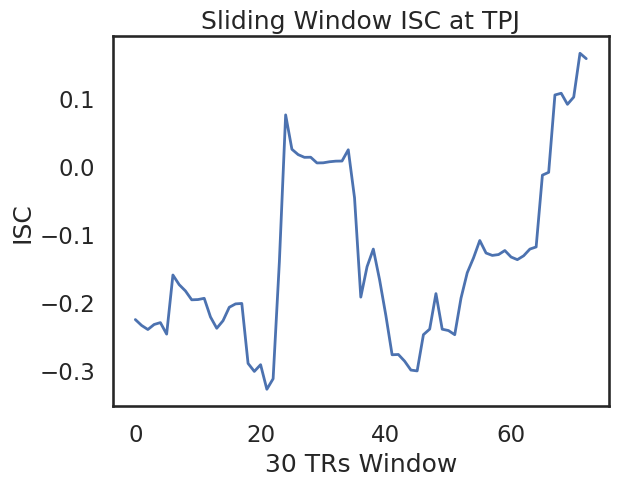

In [219]:
result4.plot()
plt.title("Sliding Window ISC at TPJ, vmPFC, HPC")
plt.xlabel("30 TRs Window")
plt.ylabel("ISC")
plt.show()

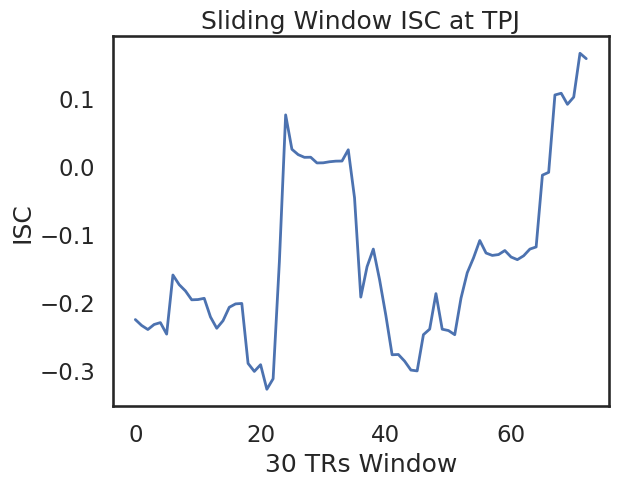

In [219]:
result.plot()
plt.title("Sliding Window ISC at TPJ")
plt.xlabel("30 TRs Window")
plt.ylabel("ISC")
plt.show()

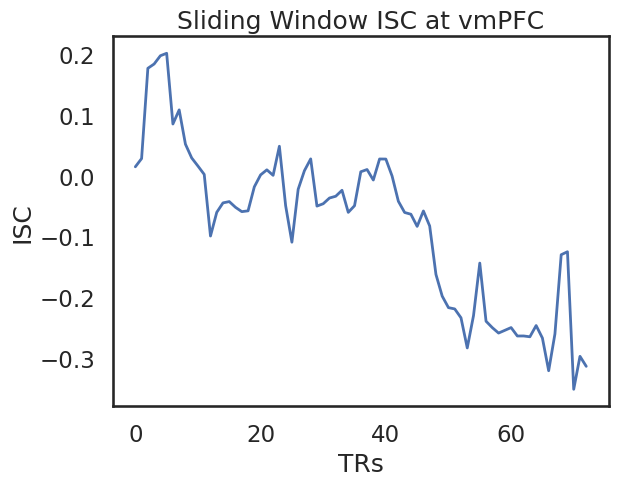

In [217]:
result.plot()
plt.title("Sliding Window ISC at vmPFC")
plt.xlabel("30 TRs Window")
plt.ylabel("ISC")
plt.show()

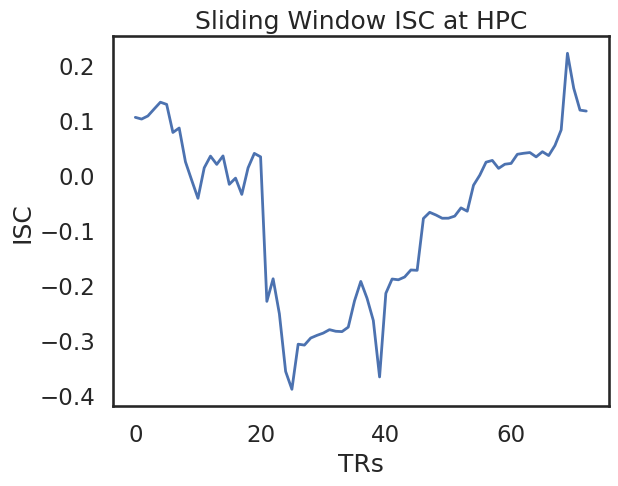

In [215]:
result.plot()
plt.title("Sliding Window ISC at HPC")
plt.xlabel("30TRs")
plt.ylabel("ISC")
plt.show()

In [191]:
import pandas as pd
data = sub_story_timeseries['sub-06'][0]
roi =28 

print(get_subject_roi(data, roi))
# 슬라이딩 타임 윈도우 크기 및 간격 설정
window_size = 30 #TR - 45secs 
stride = 1  # 윈도우 이동 간격 (일 단위)


def get_subject_roi(data, roi):
    sub_rois = {}
    for run in ['run-1','run-2']:
        sub_rois[run] = data[run].iloc[:]
    return pd.DataFrame(sub_rois)

window_isc = []
for i in range(0, data.shape[0] - window_size + 1, stride):
    window = data.iloc[i:i + window_size]
    stats = isc(get_subject_roi(sub_story_timeseries, roi), n_bootstraps=5000, metric='median', method='bootstrap')
    window_isc.append(stats['isc'])
    result = pd.Series(window_isc)
print(result)

KeyError: 'run-1'

In [169]:
data.index

RangeIndex(start=11, stop=124, step=1)

In [170]:
window_size

30

In [171]:
data.index[window_size - 1:]

RangeIndex(start=40, stop=124, step=1)